In [1]:
import os
import rasterio
from rasterio.mask import mask
from shapely.geometry import Polygon
import geopandas as gpd
import numpy as np
import joblib
from datetime import datetime

In [5]:
# Step 1: Load Time Series Data
time_series_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\time_series"

# Get the list of all TIFF files in the directory sorted by date
tif_files = sorted([f for f in os.listdir(time_series_dir) if f.endswith('.tif')])

# Load a sample TIFF file to extract coordinate bounds
sample_tif_path = os.path.join(time_series_dir, tif_files[0])

# Step 2: Determine the Coordinate Range
with rasterio.open(sample_tif_path) as src:
    bounds = src.bounds
    crs = src.crs

# Print the coordinate range
print(f"Coordinate Reference System (CRS): {crs}")
print(f"Coordinate Range (Bounding Box):")
print(f"  Min Longitude (West): {bounds.left}")
print(f"  Max Longitude (East): {bounds.right}")
print(f"  Min Latitude (South): {bounds.bottom}")
print(f"  Max Latitude (North): {bounds.top}")

# Step 3: Define the Polygon (to be done after checking the coordinate range)
# For now, we'll just print a message asking you to enter the coordinates based on the printed range.

print("\nPlease define your polygon coordinates within the above range.")

# Example placeholder for the polygon coordinates (replace with actual coordinates)
polygon_coords = [
    (bounds.left, bounds.bottom),  # Example: bottom-left corner
    (bounds.left, bounds.top),     # Example: top-left corner
    (bounds.right, bounds.top),    # Example: top-right corner
    (bounds.right, bounds.bottom)  # Example: bottom-right corner
]

# Step 4: Create the Polygon Object
polygon = Polygon(polygon_coords)

# Convert to GeoDataFrame (necessary for rasterio mask function)
gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=crs)

# # Print the coordinates of the polygon's edges for verification
# print("\nPolygon Edge Coordinates:")
# for idx, coord in enumerate(polygon.exterior.coords):
#     print(f"Edge {idx+1}: {coord}")

# # The rest of the script would go here, such as the classification and deforestation detection

Coordinate Reference System (CRS): EPSG:32720
Coordinate Range (Bounding Box):
  Min Longitude (West): 845580.0
  Max Longitude (East): 847160.0
  Min Latitude (South): 9329240.0
  Max Latitude (North): 9331190.0

Please define your polygon coordinates within the above range.


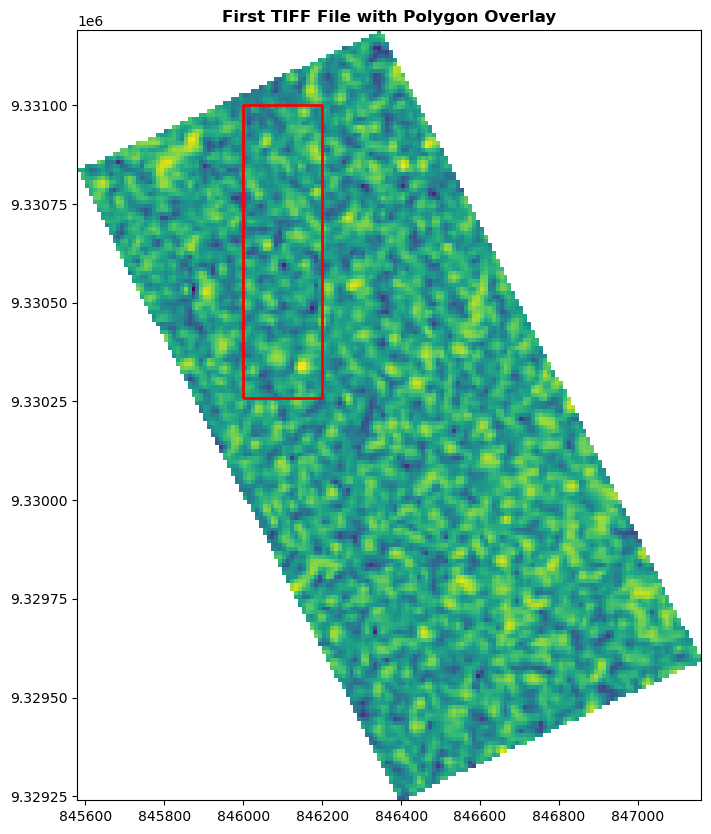

Processing file 164 out of 241...

In [ ]:
import os
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import numpy as np
import joblib
from datetime import datetime
import sys
from rasterio.plot import show  # Correctly importing the show function

# Step 1: Load the SVM Model and Scaler
model_path = r'D:\Development\RESEARCH\MarvinBlue\Results\svm_model.pkl'
svm_classifier = joblib.load(model_path)

# Load the scaler used during training to normalize the data
scaler_path = r'D:\Development\RESEARCH\MarvinBlue\Results\scaler.pkl'
scaler = joblib.load(scaler_path)

# Step 2: Define the Polygon
polygon_coords = [
    (846000.0, 9330260.0),  # Bottom-left corner
    (846000.0, 9331000.0),  # Top-left corner
    (846200.0, 9331000.0),  # Top-right corner
    (846200.0, 9330260.0)   # Bottom-right corner
]

# Create the Polygon object
polygon = Polygon(polygon_coords)

# Convert to GeoDataFrame (necessary for rasterio mask function)
gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs="EPSG:32720")  # Assuming EPSG:32720 as CRS

# Step 3: Load the TIFF Files
time_series_dir = r'D:\Development\RESEARCH\MarvinBlue\Data\time_series'
tif_files = sorted([f for f in os.listdir(time_series_dir) if f.endswith('.tif')])

# Step 4: Plot the First TIFF File with the Polygon Overlaid
def plot_tif_with_polygon(tif_path, polygon_gdf):
    with rasterio.open(tif_path) as src:
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # Plot the TIFF image (first band for visualization)
        show(src, ax=ax, title="First TIFF File with Polygon Overlay")

        # Plot the polygon on top
        polygon_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

        # Set the extent of the plot to the bounds of the image
        ax.set_xlim(src.bounds.left, src.bounds.right)
        ax.set_ylim(src.bounds.bottom, src.bounds.top)

        plt.show()

# Plot the first TIFF file with the polygon
plot_tif_with_polygon(os.path.join(time_series_dir, tif_files[0]), gdf)

# Step 5: Define the Corrected Feature Extraction Function
def extract_features_from_tile(tile):
    """
    Extract statistical features from a tile, focusing on VV, VH, and the mean of the Incidence Angle.
    """
    if np.isnan(tile).any():  # Check if the tile contains any NaN values
        return None  # Return None if there are NaN values

    tile_features = []
    
    # Process the first two bands (Band 1 - VV, Band 2 - VH)
    for band in range(2):  # Process Bands 1 and 2
        band_data = tile[band]
        tile_features.extend([
            band_data.mean(),  # Mean
            band_data.std(),   # Standard deviation
            band_data.min(),   # Min value
            band_data.max(),   # Max value
            np.median(band_data)  # Median
        ])
    
    return tile_features

# Step 6: Classification and Deforestation Detection
def classify_and_detect_deforestation(polygon_gdf, tif_files):
    previous_classification = None
    total_files = len(tif_files)

    for index, tif_file in enumerate(tif_files):
        # Print progress and clear the previous line
        sys.stdout.write(f"\rProcessing file {index + 1} out of {total_files}...")
        sys.stdout.flush()

        # Open the TIFF file and slice by polygon
        tif_path = os.path.join(time_series_dir, tif_file)
        with rasterio.open(tif_path) as src:
            # Apply the polygon mask to the raster data
            out_image, out_transform = mask(src, polygon_gdf.geometry, crop=True)
            
            # Ensure the data is in the correct format
            out_image = out_image.astype(np.float32)
            out_image = np.nan_to_num(out_image, nan=-9999)  # Replace NaNs with a placeholder

            # Extract features for each pixel within the polygon
            h, w = out_image.shape[1], out_image.shape[2]
            valid_features = []
            
            for i in range(h):
                for j in range(w):
                    tile_features = extract_features_from_tile(out_image[:, i:i+1, j:j+1])
                    if tile_features is not None:
                        valid_features.append(tile_features)

            if not valid_features:
                print(f"\nNo valid data in {tif_file} within the selected polygon.")
                continue

            valid_features = np.array(valid_features)

            # Normalize the features using the scaler
            valid_features_normalized = scaler.transform(valid_features)

            # Classify the pixels using the SVM model
            predictions = svm_classifier.predict(valid_features_normalized)
            predictions = predictions.reshape(h, w)

            # Detect deforestation by comparing with the previous classification
            if previous_classification is None:
                previous_classification = predictions
            else:
                # Determine the overlapping region
                min_h = min(previous_classification.shape[0], predictions.shape[0])
                min_w = min(previous_classification.shape[1], predictions.shape[1])

                # Compare the overlapping region
                deforestation_mask = (previous_classification[:min_h, :min_w] == 1) & (predictions[:min_h, :min_w] == 0)
                if np.any(deforestation_mask):
                    # Extract the date from the file name (assuming date is in the filename)
                    date_str = tif_file.split('_')[4]  # Adjust based on your file name pattern
                    deforestation_date = datetime.strptime(date_str, "%Y%m%dT%H%M%S").strftime('%Y-%m-%d')
                    print(f"\nDeforestation detected on: {deforestation_date}")
                    return deforestation_date
                
                # Update the previous classification with the current one
                previous_classification = predictions[:min_h, :min_w]

    print("\nNo deforestation detected in the given time series.")
    return None

# Run the deforestation detection process
deforestation_date = classify_and_detect_deforestation(gdf, tif_files)


In [ ]:
צריך לחשוב איך מגדירים מה זה לא יער ומה כן, נגיד לפי רוב הפיקסלים בדומיין, אם הם לא יער אז זה לא יער אם הם כן אז וכו...